# Calculating Summary Statistics by Hand
In the last tutorial we learned how to parse a VCF file by hand and now we are going to put that to good use! For this tutorial, we will use the parsing skills we learned earlier to calculate summary statistics by hand—given some metainformation. Let's begin by importing the packages we are going to use!

In [1]:
# Import the necessary packages.
import gzip
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd 

AMAZING! Now, we will read in the data we will use today: `tgp_biallelic_snps_chr1_first_1000_lines.vcf.gz` is a prefiltered VCF file from the TGP and `integrated_call_samples_v3.20130502.ALL.panel` is the associated metadata for the TGP.

In [2]:
# Load the vcf file.
tgp_vcf = './tgp_biallelic_snps_chr1_first_1000_lines.vcf.gz'
# Load the meta data.
tgp_panel = './integrated_call_samples_v3.20130502.ALL.panel'

GREAT! Now, let's view the metadata by reading the file in as a `pandas` data frame and inspect it!

In [3]:
# Convert the meta data to a pandas data frame.
tgp_panel_df = pd.read_csv(
    tgp_panel, sep='\t', 
    usecols=['sample', 'pop', 'super_pop', 'gender'],
)
# Inspect the data frame.
tgp_panel_df

,sample,pop,super_pop,gender
0,HG00096,GBR,EUR,male
1,HG00097,GBR,EUR,female
2,HG00099,GBR,EUR,female
3,HG00100,GBR,EUR,female
4,HG00101,GBR,EUR,male
...,...,...,...,...
2499,NA21137,GIH,SAS,female
2500,NA21141,GIH,SAS,female
2501,NA21142,GIH,SAS,female
2502,NA21143,GIH,SAS,female


We can see now that the metadata includes the population, superpopulation, and gender for each sample. What is important is that the samples are arranged in the same way as in the header of the VCF file—if this was not the case we would need to do an extra couple of steps. Let's now run a sanity check to make sure that this is true!

In [4]:
# Using the gzip package open the vcf file such that it is readable and save it to the variable data.
with gzip.open(tgp_vcf, 'rt') as data:
    # Loop through every line in the vcf file.
    for line in data:
        # If the current line is a part of the meta info...
        if line.startswith('##'):
            # Continue to the next line in the vcf file.
            continue
        # Else-if the current line is the header line.
        elif line.startswith('#'):
            # Save the header line.
            header_info = line.split()
        # Else...
        else:
            # Break the current loop.
            break
# Extract the samples from the header info and convert to a numpy array.
header_samples = np.array(header_info[9:])
# Extract the samples from the metadata.
panel_samples = tgp_panel_df['sample'].values
# Assess if the samples are in the same order.
samples_answer = np.array_equal(header_samples, panel_samples)
# Print the result.
print('It is {0} that the sampples are in the same order!'.format(samples_answer))

It is True that the sampples are in the same order!


YOU ARE KILLING IT! One thing to keep in mind is that samples in VCF files always start at index 9, this means that index 0 in the `tgp_panel_df` data frame is really index 9 in the VCF file. With this in mind and with our sanity check complete let's now use this knowledge to build a dictionary that includes the indicies for all samples in the VCF file by population.

In [5]:
# Intialize list on TGP populations.
pop_list = [
    'LWK', 'GWD', 'MSL', 'ACB', 'ASW', 'YRI', # AFR.
    'BEB', 'STU', 'ITU', 'PJL', 'GIH', # SAS.
    'CHB', 'KHV', 'CHS', 'JPT', 'CDX', # EAS.    
    'TSI', 'CEU', 'IBS', 'GBR', 'FIN', # EUR.
    'PEL', 'MXL', 'CLM', 'PUR', # AMR.
]
# Intialize a dictionary for sample indicies.
pop_dicc = {}
# For every target population.
for pop in pop_list:
    # Fill the dictionary with the pops as keys and an empty list as the value.
    pop_dicc[pop] = []
# Open the meta info file.
with open(tgp_panel, 'r') as pop_data:
    # Skip the header line.
    next(pop_data)
    # Intialize a column counter to match the indicies in the vcf file.
    col_counter = 9
    # For every line...
    for line in pop_data:
        # Split the line.
        spline = line.split()
        # Grab the current population.
        pop = spline[1]
        # If the population is a target population...
        if pop in pop_list:
            # Append the individual to the population list.
            pop_dicc[pop].append(col_counter)
            # Move the colum counter forward.
            col_counter += 1
        # Else...
        else:
            # Move the colum counter forward.
            col_counter += 1
# View the resulting dictionary keys.
pop_dicc.keys()

dict_keys(['LWK', 'GWD', 'MSL', 'ACB', 'ASW', 'YRI', 'BEB', 'STU', 'ITU', 'PJL', 'GIH', 'CHB', 'KHV', 'CHS', 'JPT', 'CDX', 'TSI', 'CEU', 'IBS', 'GBR', 'FIN', 'PEL', 'MXL', 'CLM', 'PUR'])

GREAT! We have now created a dictionary where the keys are the populations and the values are a list of all sample indicies for that population—which will come in handy to run any type of calculations! So I have essentially determined two main strategies for calculating summary statistics from VCF files the first being print as you go and the second being saving results to a dictionary. Let's start with the print as you go strategy by calculating alternative allele frequencies per population per site.

In [6]:
# Using the gzip package open the vcf file such that it is readable and save it to the variable data.
with gzip.open(tgp_vcf, 'rt') as data:
    # Intialize a vcf file to write the filtered output to.
    results_file = open('./tgp_alt_allele_freq.csv', 'w')
    # Loop through every line in the vcf file.
    for line in data:
        # If the current line is a part of the meta info or header line...
        if line.startswith('#'):
            # Continue to the next line.
            continue
        # Else...
        else:
            # Intialize an empty list to append the results to.
            line_results = []
            # Convert the line to a list by splitting the string by tabs.
            spline = line.split()
            # Grab the position number.
            pos = spline[1]
            # Append the position to the line results.
            line_results.append(pos)
            # For every population...
            for pop in pop_list:
                # Intialize the alternative allele counter.
                alt_count = 0
                # Intialize the number of samples.
                chroms = (len(pop_dicc[pop]) * 2)
                # For every individual...
                for ind in pop_dicc[pop]:
                    # Update the count of alternative alleles.
                    alt_count += spline[ind].count('1')
                # Determine the alternative allele frequency.
                alt_freq = (alt_count / chroms)
                # Append the alternative allele frequencies to the line results.
                line_results.append(str(alt_freq))
            # Write the output line as a csv.
            results_file.write(','.join(line_results)+'\n')
# Close the results file.
results_file.close()

FANTASTIC! It should be noted that the `.write()` built in function requires a string as an input which is why I converted the float to a string! Now, lets visulaize the alternative allele frequency matrix we just generated by reading the csv file to `pandas`.

In [7]:
# Convert the alternative allele frequency to a pandas data frame.
alt_freq_df = pd.read_csv(
    './tgp_alt_allele_freq.csv', sep=',', 
    names=[
        'POS',
        'LWK', 'GWD', 'MSL', 'ACB', 'ASW', 'YRI', # AFR.
        'BEB', 'STU', 'ITU', 'PJL', 'GIH', # SAS.
        'CHB', 'KHV', 'CHS', 'JPT', 'CDX', # EAS.    
        'TSI', 'CEU', 'IBS', 'GBR', 'FIN', # EUR.
        'PEL', 'MXL', 'CLM', 'PUR', # AMR.
    ],
)
# Inspect the data frame.
alt_freq_df

,POS,LWK,GWD,MSL,ACB,ASW,YRI,BEB,STU,ITU,...,CDX,TSI,CEU,IBS,GBR,FIN,PEL,MXL,CLM,PUR
0,10505,0.000000,0.0,0.0,0.005208,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10506,0.000000,0.0,0.0,0.005208,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,10511,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004808
3,10539,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.004673,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005319,0.000000
4,10542,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,91246,0.005051,0.0,0.0,0.005208,0.0,0.00463,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
741,91264,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.005814,0.0,0.0,...,0.0,0.014019,0.005051,0.014019,0.005495,0.005051,0.005882,0.015625,0.015957,0.009615
742,91303,0.005051,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
743,91340,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.004673,0.025253,0.004673,0.005495,0.000000,0.000000,0.000000,0.010638,0.000000


WOW! There you have it! An alternative allele frequency matrix! Now let's do an example of second strategy where you save the results as you go. I use this strategy a lot when I need to make calculations for every individual. This requires first building another dictionary to store the results for every individual.

In [8]:
# Intialize a dictionary for sample calculations.
ind_dicc = {}
# Open the meta info file.
with open(tgp_panel, 'r') as pop_data:
    # Skip the header line.
    next(pop_data)
    # Intialize a column counter.
    col_counter = 9
    # For every line...
    for line in pop_data:
        # Split the line.
        spline = line.split()
        # Grab the current population.
        pop = spline[1]
        # If the population is a target population...
        if pop in pop_list:
            # Intialize a counter for that indiviual.
            ind_dicc[col_counter] = {
                'HET_SITES': 0,
            }
            # Move the colum counter forward.
            col_counter += 1
        # Else...
        else:
            # Move the colum counter forward.
            col_counter += 1
# View the resulting dictionary keys.
ind_dicc.keys()

dict_keys([9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 2

WONDERFUL! So our `ind_dicc` differs from `pop_dicc` since the keys for `ind_dicc` are the sample indicies and the values are a counter for the number of heterozygous sites. Now lets actually calculate the number of heterozygous sites per individual!

In [9]:
# Using the gzip package open the vcf file such that it is readable and save it to the variable data.
with gzip.open(tgp_vcf, 'rt') as data:
    # Loop through every line in the vcf file.
    for line in data:
        # If the current line is a part of the meta info...
        if line.startswith('##'):
            # Continue to the next line in the vcf file.
            continue
        # Else-if the current line is the header line.
        elif line.startswith('#'):
            # Save the header line for saving the results.
            header_info = line.split()
        # Else...
        else:
            # Split the line.
            spline = line.split()
            # For every target population...
            for pop in pop_list:
                # For every individual in the target population...
                for ind in pop_dicc[pop]:
                    # Grab the indiviual genotype.
                    gt = spline[ind]
                    # If the genotype is heterozygous.
                    if ((gt == '0|1') | (gt == '1|0')):
                        # Append the counter.
                        ind_dicc[ind]['HET_SITES'] += 1
                    # Else...
                    else:
                        # Continue to the next individual.
                        continue
# Intialize a results file.
results_file = open('./tgp_het_sites.csv', 'w')
# For all target populations...
for pop in pop_list:
    # For all individuals in that population...
    for ind in pop_dicc[pop]:
        # Compile the results for that individual.
        result_line = [
            pop,
            header_info[ind],
            str(ind_dicc[ind]['HET_SITES']),
        ]
        # Write the results line to the results file.
        results_file.write(','.join(result_line)+'\n')
# Close the results file.
results_file.close()

ABSOLUTELY AMAZING!!! Now lets visualize these results that we just generated using `matplotlib`. To do so I will first load the results into `pandas`.

In [10]:
# Convert the heterozygous sites to a pandas data frame.
het_sites_df = pd.read_csv(
    './tgp_het_sites.csv', sep=',', 
    names=[
        'POP', 'IND', 'HET_SITES'
    ],
)
# Inspect the data frame.
het_sites_df

,POP,IND,HET_SITES
0,LWK,NA19017,19
1,LWK,NA19019,13
2,LWK,NA19020,10
3,LWK,NA19023,18
4,LWK,NA19024,18
...,...,...,...
2400,PUR,HG01403,18
2401,PUR,HG01405,10
2402,PUR,HG01412,12
2403,PUR,HG01413,10


Next, we will build a list of population specific heterozygous sites arrays.

In [11]:
# Compile the results to one list.
tgp_het_sites = [
    het_sites_df[het_sites_df['POP'] == 'LWK']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'GWD']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'MSL']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'ACB']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'ASW']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'YRI']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'BEB']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'STU']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'ITU']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'PJL']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'GIH']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'CHB']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'KHV']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'CHS']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'JPT']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'CDX']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'TSI']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'CEU']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'IBS']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'GBR']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'FIN']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'PEL']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'MXL']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'CLM']['HET_SITES'].values,
    het_sites_df[het_sites_df['POP'] == 'PUR']['HET_SITES'].values,
]

BRILLIANT! The last thing we will do is build a violin plot with jitter using `matplotlib`.

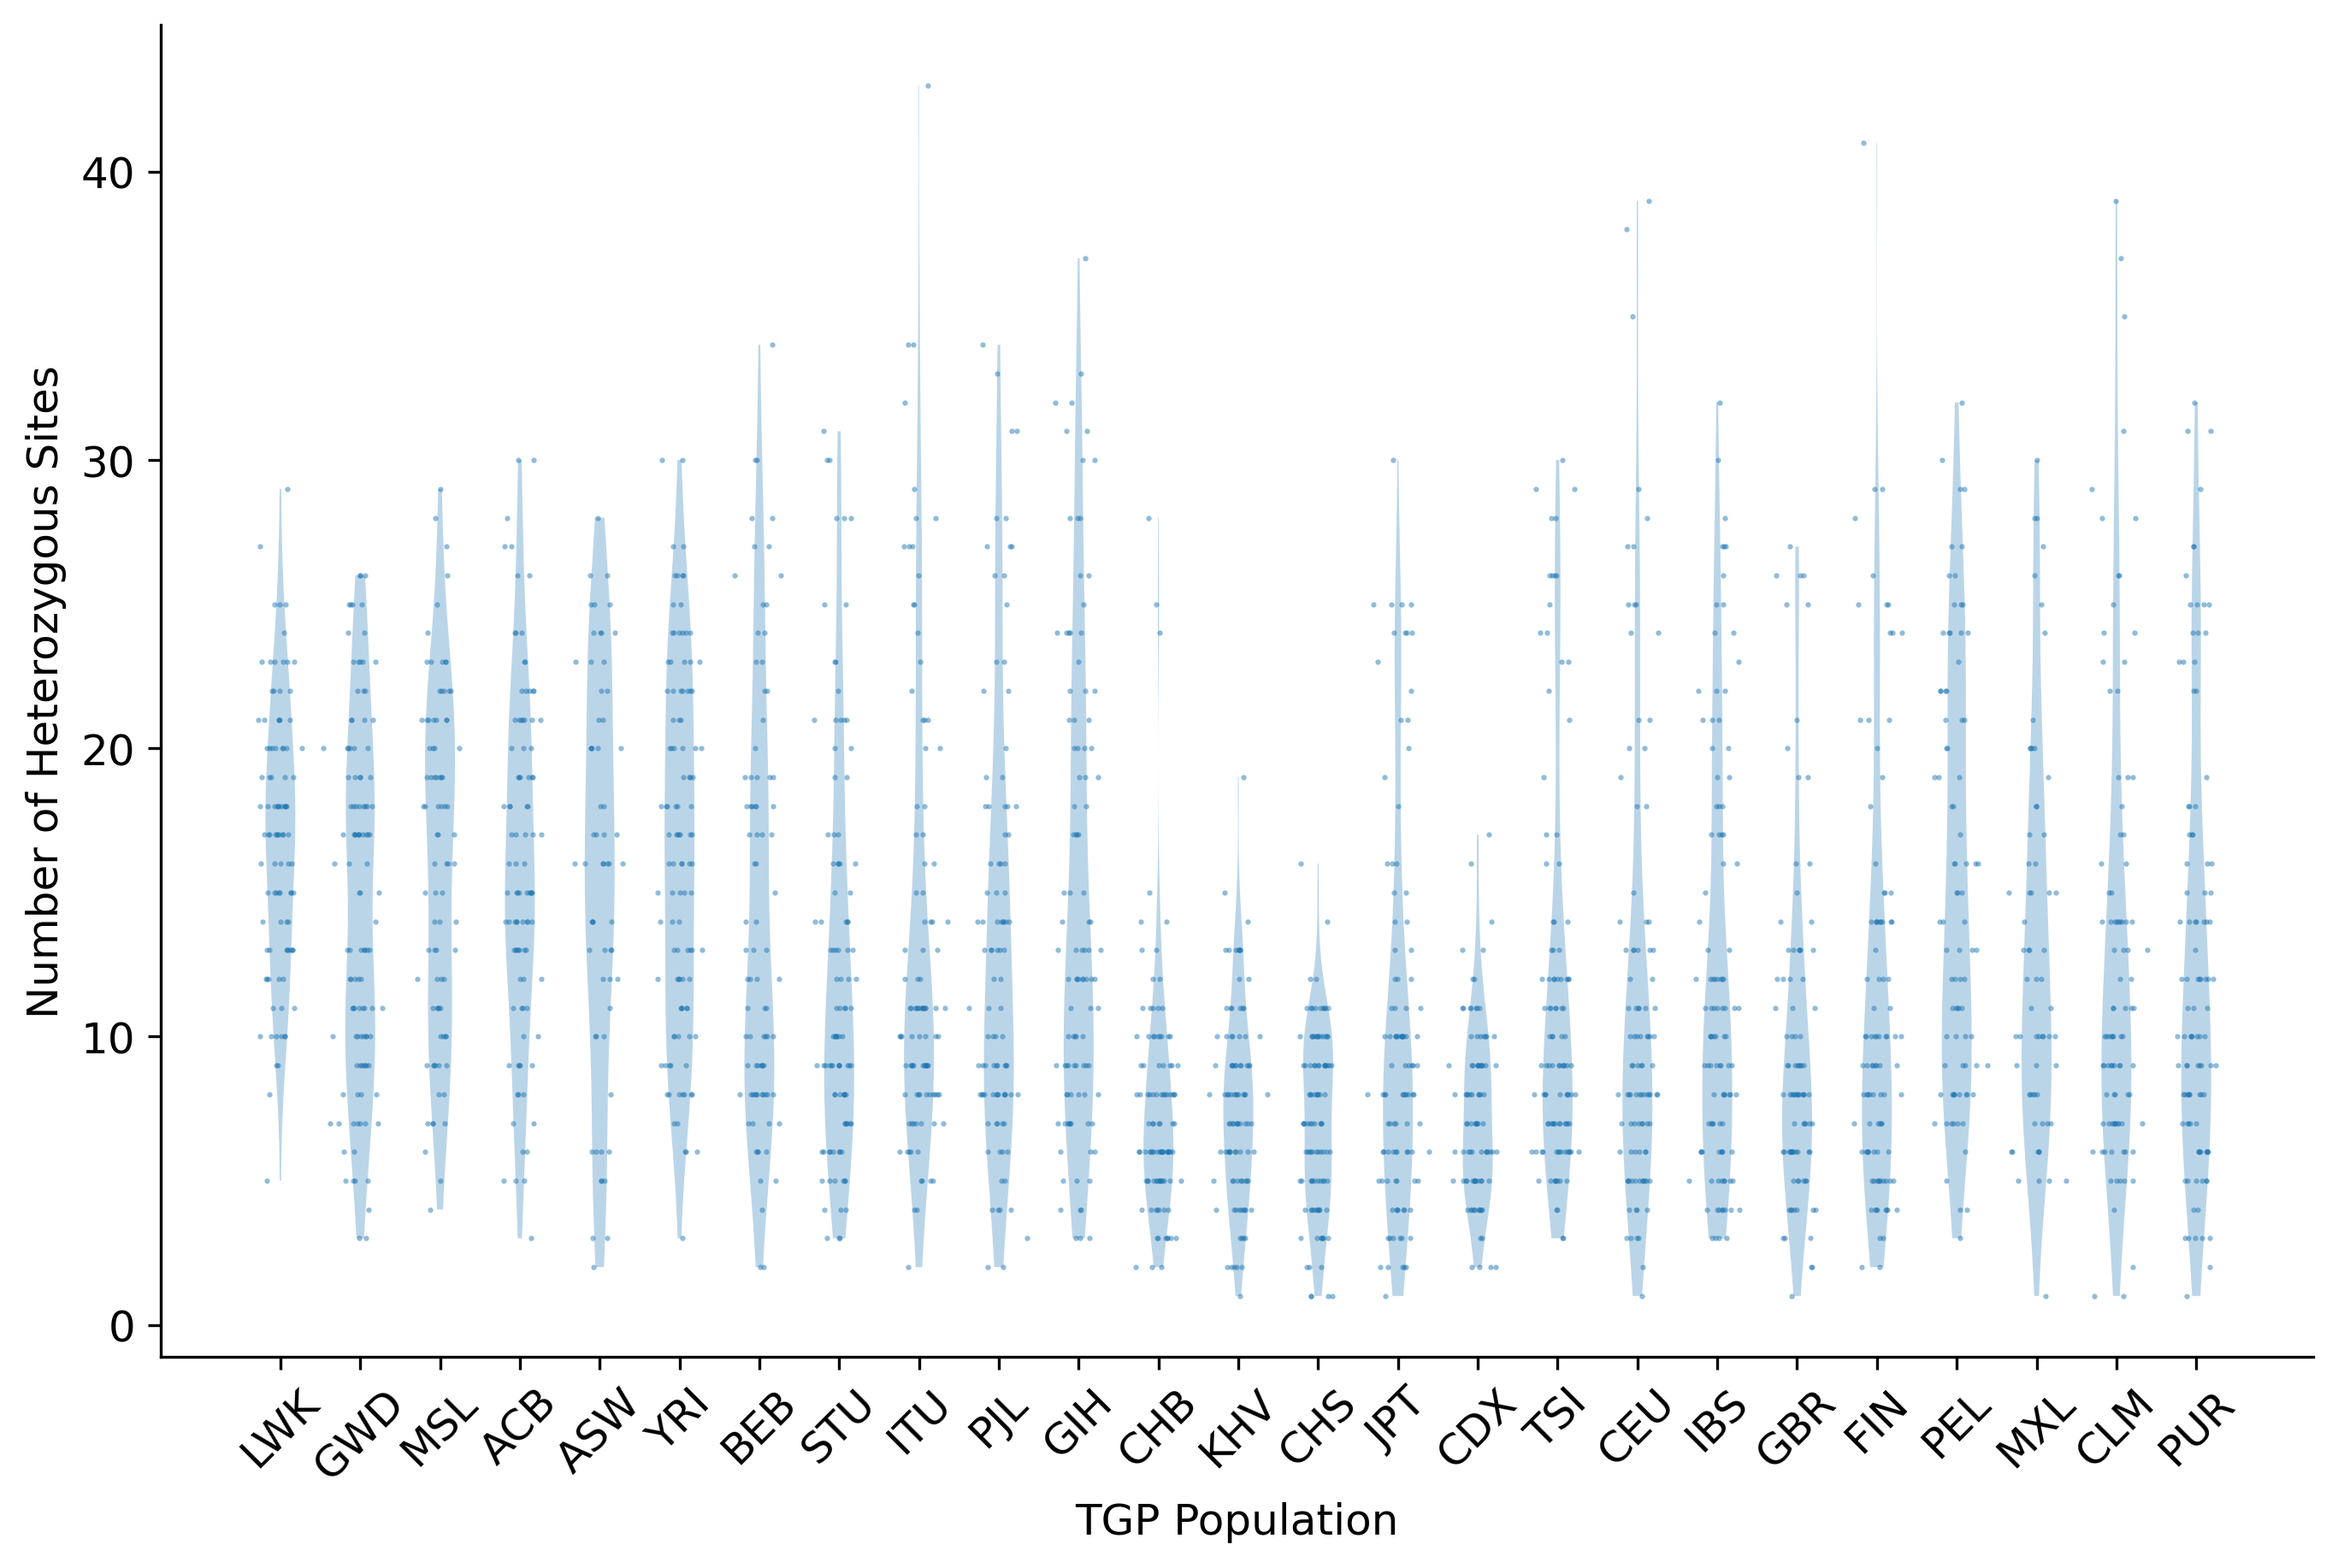

In [12]:
# Set the positions.
tgp_pos = np.arange(0, 50, 2)
# Intialize the style.
plt.rcParams.update({'font.size': 12})
# Intialize the figure.
fig = plt.figure(figsize=(9,6), constrained_layout=True, dpi=300.0)
# Intialize the axis.
ax = fig.add_subplot(111)
# Plot the results.
ax.violinplot(tgp_het_sites, tgp_pos, vert=True, showextrema=False, widths=0.75)
# Set the index counter.
idx_counter = 0
# For every x-axis tick.
for i in tgp_pos:
    # Grab the data points.
    y = tgp_het_sites[idx_counter]
    # Move the index counter forward.
    idx_counter += 1
    # Add some jitter to the x-axis.
    x = np.random.normal(i, 0.25, size=len(y))
    # Plot the points!
    ax.scatter(x, y, color='tab:blue', marker='.', s=1, alpha=0.5)
# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Set the axes labels.
plt.xlabel('TGP Population')
plt.ylabel('Number of Heterozygous Sites')
# Set the x-axis tick positions and labels.
ax.set_xticks(tgp_pos)
ax.set_xticklabels(pop_list, rotation=45)
# Show!
plt.show()